# Problem Statement

Using NLP to analyze Yelp reviews data


In [642]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


from sklearn.feature_extraction.text import CountVectorizer
import string
string.punctuation
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [643]:
yelp_df = pd.read_csv("yelp_review.csv", 
                        delimiter='\t', 
                        header=None, 
                        names=['Review', 'sentiment'])

In [644]:
yelp_df

,Review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [645]:
yelp_df.describe()

,sentiment
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [646]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


# Visualize Dataset

In [647]:
# Let's get the length of the messages
yelp_df['length'] = yelp_df['Review'].apply(len)
yelp_df.head()

,Review,sentiment,length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59


<AxesSubplot:ylabel='Frequency'>

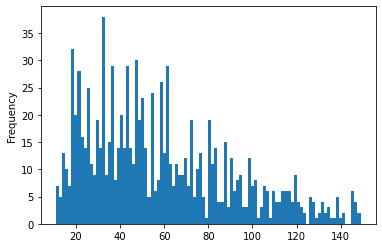

In [648]:
yelp_df['length'].plot(bins=100, kind='hist') 

In [649]:
yelp_df.length.describe()

count    1000.00000
mean       58.31600
std        32.36414
min        11.00000
25%        33.00000
50%        51.00000
75%        80.00000
max       149.00000
Name: length, dtype: float64

In [650]:
yelp_df[yelp_df['length'] == 149]['Review'].iloc[0]

'The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).'

In [651]:
yelp_df[yelp_df['length'] == 11]['Review'].iloc[0]

'DELICIOUS!!'

In [652]:
# Let's see the message with mean length 
yelp_df[yelp_df['length'] == 58]['Review'].iloc[0]

'I found this place by accident and I could not be happier.'

In [653]:
yelp_df

,Review,sentiment,length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59
...,...,...,...
995,I think food should have flavor and texture an...,0,66
996,Appetite instantly gone.,0,24
997,Overall I was not impressed and would not go b...,0,50
998,"The whole experience was underwhelming, and I ...",0,91


In [654]:
yelp_df_1 = yelp_df[yelp_df['sentiment']==1]

In [655]:
yelp_df_1

,Review,sentiment,length
0,Wow... Loved this place.,1,24
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59
8,The fries were great too.,1,25
9,A great touch.,1,14
...,...,...,...
899,"Overall, a great experience.",1,28
901,Their regular toasted bread was equally satisf...,1,97
907,The chips and sals a here is amazing!!!!!!!!!!...,1,55
909,This is my new fav Vegas buffet spot.,1,37


In [656]:
yelp_df_0 = yelp_df[yelp_df['sentiment']==0]

In [657]:
yelp_df_0

,Review,sentiment,length
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
5,Now I am getting angry and I want my damn pho.,0,46
6,Honeslty it didn't taste THAT fresh.),0,37
7,The potatoes were like rubber and you could te...,0,111
...,...,...,...
995,I think food should have flavor and texture an...,0,66
996,Appetite instantly gone.,0,24
997,Overall I was not impressed and would not go b...,0,50
998,"The whole experience was underwhelming, and I ...",0,91


In [658]:
yelp_df_0_1 = pd.concat([yelp_df_0,yelp_df_1])

In [659]:
yelp_df_0_1

,Review,sentiment,length
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
5,Now I am getting angry and I want my damn pho.,0,46
6,Honeslty it didn't taste THAT fresh.),0,37
7,The potatoes were like rubber and you could te...,0,111
...,...,...,...
899,"Overall, a great experience.",1,28
901,Their regular toasted bread was equally satisf...,1,97
907,The chips and sals a here is amazing!!!!!!!!!!...,1,55
909,This is my new fav Vegas buffet spot.,1,37


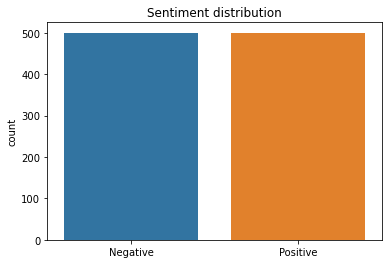

In [660]:
plt_sentiment = sns.countplot(x='sentiment', data=yelp_df)
plt_sentiment.set_title("Sentiment distribution")
plt_sentiment.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

# Create Training and testing dataset

# Removal Punctuation and StopWords

In [661]:
def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [662]:
class Tokenizer:
    def clean(self, text):
        no_html = BeautifulSoup(text).get_text()
        clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
        return re.sub("(\s+)", " ", clean)

    def tokenize(self,message):
        clean = self.clean(message).lower()
        remove_punctuation = [char for char in message if char not in string.punctuation]
        remove_punc_join = ''.join(remove_punctuation)
        remove_punc_join_clean = [word for word in remove_punc_join.split() if clean not in stopwords.words('english')]
        return remove_punc_join_clean
        

In [663]:
yelp_df_clean = yelp_df_0_1['Review'].apply(message_cleaning)

In [664]:
yelp_df_clean[0]

['Wow', 'Loved', 'place']

In [665]:
print(yelp_df_0_1['Review'][0]) # show the original version

Wow... Loved this place.


In [666]:
from sklearn.feature_extraction.text import CountVectorizer
# Define the cleaning pipeline we defined earlier
vectorizer = CountVectorizer(analyzer = message_cleaning)
yelp_countvectorizer = vectorizer.fit_transform(yelp_df_0_1['Review'])


In [667]:
print(vectorizer.get_feature_names())

['1', '10', '100', '1199', '12', '15', '15lb', '17', '1979', '2', '20', '2007', '23', '3', '30', '30s', '34ths', '35', '4', '40', '400', '40min', '45', '5', '6', '7', '70', '785', '8', '90', 'APPETIZERS', 'AVOID', 'AYCE', 'AZ', 'Albondigas', 'Also', 'Although', 'Always', 'Ambience', 'Ample', 'Anyway', 'Anyways', 'Appetite', 'Area', 'Aria', 'Attack', 'Avoid', 'Awesome', 'Awful', 'BACK', 'BARE', 'BARGAIN', 'BBQ', 'BEST', 'BETTER', 'BITCHES', 'BLAND', 'Baba', 'Bachi', 'Back', 'Bacon', 'Bad', 'Bar', 'Baseball', 'Based', 'Bay', 'Bean', 'Bellagio', 'Best', 'Big', 'Bisque', 'Blah', 'Bland', 'Bloody', 'Bouchon', 'Boy', 'Breeze', 'Brushfire', 'Buffet', 'Buldogis', 'Burger', 'Burrittos', 'Bussell', 'CONCLUSION', 'Caballeros', 'Caesar', 'Café', 'Camelback', 'Cant', 'Cape', 'Carlys', 'Cartel', 'Casino', 'Check', 'Chicken', 'Chinese', 'Chipotle', 'Christmas', 'Cibo', 'Classywarm', 'Cod', 'Coffee', 'Come', 'Coming', 'Company', 'Con', 'Cooked', 'Costcos', 'Cotta', 'Couldnt', 'Crema', 'Crostini', 'Cru

In [668]:
print(yelp_countvectorizer.toarray())  

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [669]:
yelp_countvectorizer.shape

(1000, 2160)

# Training the Model

In [670]:
from sklearn.model_selection import train_test_split
import numpy as np

X = yelp_countvectorizer
y = yelp_df_0_1['sentiment'].values

In [671]:
X

<1000x2160 sparse matrix of type '<class 'numpy.int64'>'
	with 5606 stored elements in Compressed Sparse Row format>

In [672]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [673]:
text = " ".join(review for review in yelp_df.Review)

In [674]:
text

'Wow... Loved this place. Crust is not good. Not tasty and the texture was just nasty. Stopped by during the late May bank holiday off Rick Steve recommendation and loved it. The selection on the menu was great and so were the prices. Now I am getting angry and I want my damn pho. Honeslty it didn\'t taste THAT fresh.) The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer. The fries were great too. A great touch. Service was very prompt. Would not go back. The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced. I tried the Cape Cod ravoli, chicken,with cranberry...mmmm! I was disgusted because I was pretty sure that was human hair. I was shocked because no signs indicate cash only. Highly recommended. Waitress was a little slow in service. This place is not worth your time, let alone Vegas. did not like at all. The Burrittos Blah! The food, amazing. Service is also cute. I could care le

In [675]:
#class Multinomial Naive Baye Classifier without using any libraries

#Reference Link: https://stackoverflow.com/q
#uestions/60969884/multinomial-naive-bayes-for-python-from-scratch
#https://www.youtube.com/watch?v=3trW5Lig7BU
#Reference Link:https://colab.research.google.com/drive/1OPQDDJTKy0b40pziZWSsoBCmQV6HyXsm#scrollTo=JnOAO_Kl4BkQ
class naiveBayes:
    def __init__(self, classes, tokenizer):
        self.tokenizer = tokenizer
        self.classes = classes
      
    def group_by_class(self, X, y):
        data = dict()
        for c in self.classes:
            data[c] = X[np.where(y == c)]
            
        return data
    def fit(self, X,y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
            self.n_class_items[c] = len(data)
            self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
            self.word_counts[c] = defaultdict(lambda: 0)
            for text in data:
                counts = Counter(self.tokenizer.tokenize(text))
                for word, count in counts.items():
                    if word not in self.vocab:
                        self.vocab.add(word)

                    self.word_counts[c][word] += count
                
        return self
    def laplace_smoothing(self,word,text_class):
        num = self.word_counts[text_class][word] + 1
        denom = self.n_class_items[text_class] + len(self.vocab)
        return math.log(num / denom)
    def predict(self, X):
        result = []
        for text in X:
            class_scores = {c: self.log_class_priors[c] for c in self.classes}

            words = set(self.tokenizer.tokenize(text))
            for word in words:
                if word not in self.vocab: continue

                for c in self.classes:
                    log_w_given_c = self.laplace_smoothing(word, c)
                    class_scores[c] += log_w_given_c
                
            result.append(max(class_scores, key=class_scores.get))

        return result

        

In [676]:
X = yelp_df['Review'].values
y = yelp_df['sentiment'].values

  
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

classifier = naiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()).fit(X_train, y_train)
# Predicting test results
y_pred = classifier.predict(X_test)


C:\Users\nisch\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "Con: spotty service." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [677]:
accuracy_score(y_test, y_pred)

0.7933333333333333

In [678]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        71
           1       0.86      0.72      0.79        79

    accuracy                           0.79       150
   macro avg       0.80      0.80      0.79       150
weighted avg       0.80      0.79      0.79       150



In [679]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [680]:
conf_matrix

array([[62,  9],
       [22, 57]], dtype=int64)

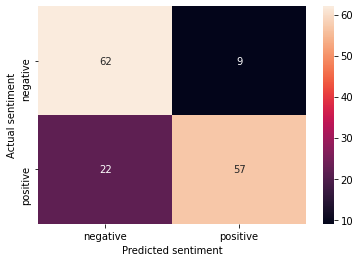

In [681]:
class_names = ["negative", "positive"]
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');